In [23]:
import pandas as pd
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import regex as re
nltk.download('omw-1.4')
from nltk import word_tokenize
import collections
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
pd.options.mode.chained_assignment = None
import numpy as np
from scipy.spatial import distance
import spacy
#from spacy_langdetect import LanguageDetector
#from textblob import TextBlob
import langdetect
from langdetect import detect
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from functools import reduce
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk.stem import *
from nltk.stem.snowball import SnowballStemmer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/murieldegroot/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/murieldegroot/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


I choose to use Spacy for stopwords as it consists of more stopwords

In [24]:
nltk_stopwords = stopwords.words("english")
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words in nltk: %d' % len(nltk_stopwords))
print('Number of stop words in spacy: %d' % len(spacy_stopwords))

Number of stop words in nltk: 179
Number of stop words in spacy: 326


In [25]:
#parameters
N = 10 #top n words

Read Excel files and merge them

In [26]:
vragendf = pd.read_excel("/Users/murieldegroot/UvA/Joris Huese - Muriël/data/UvAQ_openvragen_JHUESE_1_7_22.xlsx")

/Users/murieldegroot/opt/anaconda3/envs/stage/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


KeyboardInterrupt: 

In [27]:
collegedf = pd.read_csv("/Users/murieldegroot/UvA/Joris Huese - Muriël/data/SchoolCollege.csv")

In [28]:
pre_df = vragendf.merge(collegedf)
pre_df = pre_df.rename(columns={"Unnamed: 2": "Vakcode", "Vragen Uniform": "Vragen", "Resultaat tekst":"Antwoord", "SchoolCollege": "College"})
pre_df = pre_df.replace({'College' : { "College of Psychology" : "Psychology", "College of Communication" : "Communication", "College of Social Sciences" : "Social_Sciences"}})

In [29]:
pre_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386928 entries, 0 to 386927
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Evaluatietaal       386928 non-null  object 
 1   Vak                 386928 non-null  object 
 2   Vakcode             386928 non-null  object 
 3   Periode             386928 non-null  object 
 4   Vragen              386928 non-null  object 
 5   Resultaat sheet ID  386928 non-null  int64  
 6   UQ volgnummer 2     386928 non-null  int64  
 7   Antwoord            386754 non-null  object 
 8   Faculteit           386928 non-null  object 
 9   Opleiding           386928 non-null  object 
 10  Aantal records      386928 non-null  float64
 11  College             386928 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 38.4+ MB


In [30]:
len(pre_df["Antwoord"].unique())

372766

In [31]:
len(pre_df)

386928

In [32]:
pre_df["College"].value_counts().head()

Social_Sciences                               128662
Communication                                  73965
Psychology                                     52875
Graduate School of Social Sciences             41418
College of Child Development and Education     38051
Name: College, dtype: int64

There are only null values in the antwoord column: 174 in total. Remove the rows that have this.

In [33]:
#pre_df = pre_df.dropna(subset=['Antwoord', 'Vragen', 'Periode', 'Resultaat sheet ID', 'Opleiding'])
pre_df = pre_df.dropna(subset=['Antwoord'])
pre_df = pre_df[pre_df['Antwoord'] != '.']
pre_df = pre_df[pre_df['Antwoord'] != ',']
pre_df = pre_df[pre_df['Antwoord'] != '-']
pre_df = pre_df[pre_df['Antwoord'] != '/']
pre_df = pre_df[pre_df['Antwoord'] != 'none']
len(pre_df)

383154

Concatenate answers. Result sheet ID is a unique ID number of a student who answers a question. The ID number is not unique on the entire population, but only on specific subject & period level. The sequence number is a row counter, which keeps track of which rows belong together for that specific person. That's why you group by: group_by(Subject, Result sheet ID, Questions Uniform, Period). After that you can paste all sequential numbers together because the grouped features guarantee that you only have text from a unique person on a unique question at a unique time

In [34]:
pre_df['Antwoord'] = pre_df.groupby(['Periode', 'Vragen', 'Resultaat sheet ID', 'Vak'])["Antwoord"].transform(lambda x : "".join(x))
len(pre_df)

383154

In [35]:
pre_df = pre_df.drop_duplicates("Antwoord")
pre_df = pre_df[pre_df['Antwoord'] != '.']
len(pre_df)

78159

In [36]:
pre_df = pre_df.reset_index(drop=True)
#del df['index']
#del df['level_0']

In [38]:
def language(s):
    lang = detect(s)
    return lang

In [39]:
def preprocess(s):
    
    wnl = WordNetLemmatizer()
    
    s = re.sub(r'[^a-zA-Z ]', ' ', s) # remove punctuation/non-alpha
    s = re.sub("\d+", "", s) #remove digits
    s = s.lower() # make lowercase
    s = re.sub(r'  +',' ', s) #remove double spaces
    s = re.sub(r'\b\w{1,2}\b', '', s) #remove words with 2 characters or less

    lst = nltk.word_tokenize(s) #tokenize words
    words = ' '.join([wnl.lemmatize(words) for words in lst]) #lemmatize words

    return words

In [42]:
def clean(s):
    
    s = re.sub(r'[^a-zA-Z ]', ' ', s) # remove punctuation/non-alpha
    s = re.sub("\d+", "", s) #remove digits
    s = s.lower() # make lowercase
    s = re.sub(r'  +',' ', s) #remove double spaces

    return s

WordNetLemmatizer not ideal -> it transforms 'was' into 'wa'. Also: cannot find lemmatizer for Dutch

In [43]:
wnl = WordNetLemmatizer()
lst = ['course','courses','lecture','lecturer','lectures','was']
words = ' '.join([wnl.lemmatize(words) for words in lst])
print("Original:", lst)
print("Lemmatized:", words)

Original: ['course', 'courses', 'lecture', 'lecturer', 'lectures', 'was']
Lemmatized: course course lecture lecturer lecture wa


In [45]:
def remove_stopw(s):
    words = word_tokenize(s)
    no_sw_lst = []
    st_words = spacy_stopwords
    st_words_nl = stopwords.words("dutch") + ["vond","goed","wel","erg","heel","wa","echt"]
    #st_words_nl.extend(["vond","goed","wel","erg","heel","wa","echt"])
    st_words.update(st_words_nl)
    for w in words:
        if w not in st_words:
            no_sw_lst.append(w)
    no_sw = ' '.join(no_sw_lst)
    return no_sw

In [46]:
def tokenized(s):
    words = nltk.word_tokenize(s)
    return words

In [47]:
def length(s):
    return len(s)

Stemmer does not work properly. Workaround: hardcoded synonyms/stemmers

In [48]:
def dutch_stemmer(s):
    stemmer = SnowballStemmer("dutch")
    lst = nltk.word_tokenize(s)
    words = ' '.join([stemmer.stem(words) for words in lst])
    return(words)

In [49]:
string = "leraren geven hoorcolleges en tentamens en colleges"
dutch_stemmer(string)

'lerar gev hoorcolleges en tentamen en colleges'

In [76]:
df = pre_df
df['Preprocessed'] = df['Antwoord'].apply(preprocess)
df['Zonder sw'] = df['Preprocessed'].apply(remove_stopw)
df['Words'] = df['Zonder sw'].apply(tokenized)
df["Response length"] = df["Words"].apply(length)
len(df)

77969

In [77]:
df.head()

,Evaluatietaal,Vak,Vakcode,Periode,Vragen,Resultaat sheet ID,UQ volgnummer 2,Antwoord,Faculteit,Opleiding,Aantal records,College,Preprocessed,Zonder sw,Cleaned_complete,Words,Response length,Language
0,Engels,"""Stop right here """"",7334D0130,20-21/S2B1,Wat heb je gewaardeerd in dit vak?,0,1,"I really like the choice of literature, i lear...",Maatschappij- en Gedragswetenschappen,Sociologie (Ma),1.0,Graduate School of Social Sciences,really like the choice literature learned many...,like choice literature learned new thing haven...,like choice literature learned new thing haven...,"[like, choice, literature, learned, new, thing...",33,en
1,Engels,"""Stop right here """"",7334D0130,20-21/S2B1,Wat heb je gewaardeerd in dit vak?,2,1,I appreciated the content of the course. I tho...,Maatschappij- en Gedragswetenschappen,Sociologie (Ma),1.0,Graduate School of Social Sciences,appreciated the content the course thought the...,appreciated content course thought topic cover...,appreciated content course thought topic cover...,"[appreciated, content, course, thought, topic,...",9,en
2,Engels,"""Stop right here """"",7334D0130,20-21/S2B1,Wat vond je het beste voorbeeld van de aanpak ...,0,1,I would have liked even more pre- recorded vid...,Maatschappij- en Gedragswetenschappen,Sociologie (Ma),1.0,Graduate School of Social Sciences,would have liked even more pre recorded video ...,liked pre recorded video loved audio version l...,liked pre recorded video loved audio version l...,"[liked, pre, recorded, video, loved, audio, ve...",8,en
3,Engels,"""Stop right here """"",7334D0130,20-21/S2B1,Wat vond je het beste voorbeeld van de aanpak ...,2,1,Having small seminar groups facilitated online...,Maatschappij- en Gedragswetenschappen,Sociologie (Ma),1.0,Graduate School of Social Sciences,having small seminar group facilitated online ...,having small seminar group facilitated online ...,having small seminar group facilitated online ...,"[having, small, seminar, group, facilitated, o...",11,en
4,Engels,"""Stop right here """"",7334D0130,20-21/S2B1,"Welke aanpassingen zou jij voorstellen, als he...",0,1,"Nothing really, it was a very good decision to...",Maatschappij- en Gedragswetenschappen,Sociologie (Ma),1.0,Graduate School of Social Sciences,nothing really wa very good decision split the...,good decision split group smaller,good decision split group smaller,"[good, decision, split, group, smaller]",5,en


In [52]:
nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.replace("none", nan_value, inplace=True)
df.replace("nvt", nan_value, inplace=True)
df.dropna(subset = ["Preprocessed"], inplace=True)
len(df)

77969

In [53]:
df["Language"] = df['Preprocessed'].apply(language)

In [94]:
df_nl = df.loc[df['Evaluatietaal'] == "Nederlands"]
df_en = df.loc[df['Evaluatietaal'] == "Engels"]
print('Number of Dutch responses: %d' % len(df_nl))
print('Number of English responses: %d' % len(df_en))

Number of Dutch responses: 23899
Number of English responses: 54070


In [55]:
len(df_nl)/(len(df_nl)+len(df_en))

0.3065192576536829

In [95]:
df_nl_2 = df_en.loc[df['Language'] == "nl"]
df_en_2 = df_nl.loc[df['Language'] == "en"]

print('Number of Dutch responses found in English df: %d' % len(df_nl_2))
print('Number of English responses found in Dutch df: %d' % len(df_en_2))

Number of Dutch responses found in English df: 3272
Number of English responses found in Dutch df: 156


In [96]:
#1. remove dutch responses from df_en and english responses from df_nl
df_en.drop(df_en[df_en.Language == "nl"].index, inplace = True)
df_nl.drop(df_nl[df_nl.Language == "en"].index, inplace = True)

#2. add detected english responses (df_en_2) to df_en and add detected dutch responses (df_nl_2) to df_nl
df_en = pd.concat([df_en, df_en_2])
df_en = df_en.reset_index(drop=True)
df_nl = pd.concat([df_nl, df_nl_2])
df_nl = df_nl.reset_index(drop=True)

In [97]:
print('Length of english df: %d' % len(df_en))
print('Length of dutch df: %d' % len(df_nl))

Length of english df: 50954
Length of dutch df: 27015


English: A balanced dataset of 3 different Colleges is created

In [98]:
balanced_data = []

df_psy = df_en[df_en['College']=='Psychology']
balanced_data.append(len(df_psy))
print('Length of English df_psy: %d' % len(df_psy))

df_comm = df_en[df_en['College']=='Communication']
balanced_data.append(len(df_comm))
print('Length of English df_comm: %d' % len(df_comm))

df_soc = df_en[df_en['College']=='Social_Sciences']
balanced_data.append(len(df_soc))

print('Length of English df_soc: %d' % len(df_soc))
X = min(balanced_data)
X

Length of English df_psy: 9362
Length of English df_comm: 11286
Length of English df_soc: 17222


9362

In [99]:
df_psy = df_psy[:X]
df_psy.reset_index(inplace=True, drop=True)

df_comm = df_comm[:X]
df_comm.reset_index(inplace=True, drop=True)

df_soc = df_soc[:X]
df_soc.reset_index(inplace=True, drop=True)

In [118]:
print(df_psy["Antwoord"][0])
print(df_psy["Preprocessed"][0])
print(df_psy["Zonder sw"][0])
print(df_psy["Words"][0])


All tutors and lecturers are very welcoming and friendly.
all tutor and lecturer are very welcoming and friendly
tutor lecturer welcoming friendly
['tutor', 'lecturer', 'welcoming', 'friendly']


Psychology wordcloud

All english psychology answers combined result in 1209695 words.


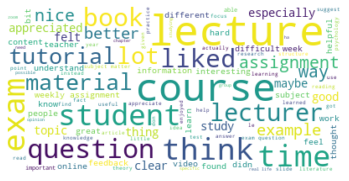

In [62]:
psy_text = " ".join(answer for answer in df_psy.Cleaned_complete.astype(str))
print ("All english psychology answers combined result in {} words.".format(len(psy_text)))
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(psy_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Communication wordcloud

All english communication answers combined result in 1155948 words.


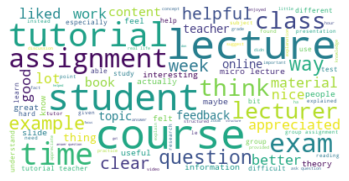

In [63]:
comm_text = " ".join(answer for answer in df_comm.Cleaned_complete.astype(str))
print ("All english communication answers combined result in {} words.".format(len(comm_text)))
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(comm_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Sociology wordcloud

All english sociology answers combined result in 1332745 words.


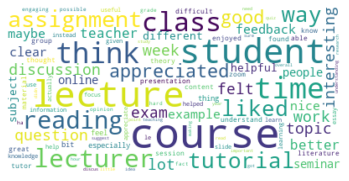

In [64]:
soc_text = " ".join(answer for answer in df_soc.Cleaned_complete.astype(str))
print ("All english sociology answers combined result in {} words.".format(len(soc_text)))
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(soc_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

As you can see from the three wordclouds above, there are no major differences in word usage at first sight

Combined wordcloud

All english answers combined result in 7442271 words.


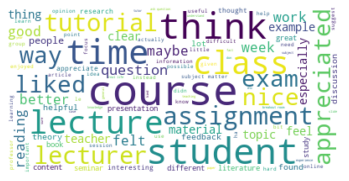

In [104]:
text = " ".join(answer for answer in df_en.Cleaned_complete.astype(str))
print ("All english answers combined result in {} words.".format(len(text)))
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("/Users/murieldegroot/UvA/Joris Huese - Muriël/experiments/wordcloud.png")

In [100]:
df_master = pd.concat([df_psy,df_soc,df_comm])
df_master = df_master[["College","Words"]]
#df_master = df_master[["index", "College","Words"]]
df_master = df_master.explode("Words")
df_master = df_master.groupby("College")["Words"].value_counts()
df_master = df_master.reset_index(name="Count")
df_master["Fraction"] = df_master["Count"]/(X*3)
df_master["Rank"] = df_master.groupby("College")["Count"].rank("dense", ascending=False)
df_master = df_master.groupby("College").head(X)
df_subset = df_master.groupby("College").head(N)
df_subset = df_master[df_master['Words'].isin(df_subset["Words"])]
df_subset

,College,Words,Count,Fraction,Rank
0,Communication,lecture,3681,0.131062,1.0
1,Communication,course,2698,0.096062,2.0
2,Communication,tutorial,2391,0.085131,3.0
3,Communication,assignment,2204,0.078473,4.0
4,Communication,question,1955,0.069608,5.0
5,Communication,student,1822,0.064872,6.0
6,Communication,time,1818,0.064730,7.0
7,Communication,exam,1761,0.062700,8.0
8,Communication,lecturer,1311,0.046678,9.0
9,Communication,material,1207,0.042975,10.0


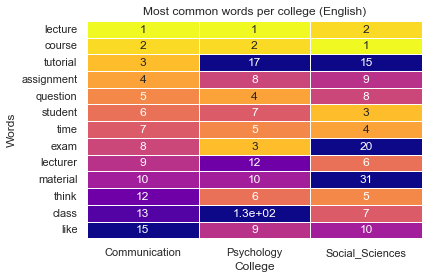

In [85]:
df_heatmap = df_subset[["College","Words","Rank"]]
df_heatmap = df_heatmap.reset_index(drop=True)
df_heatmap = df_heatmap.pivot(index="Words", columns="College", values="Rank")
df_heatmap = df_heatmap.sort_values(df_heatmap.columns[0])
ax = sns.heatmap(df_heatmap, vmax=15, cmap="plasma_r", annot=True, cbar=False, linewidths=.5,)
ax.set_title('Most common words per college (English)')
plt.show()
fig = ax.get_figure()
fig.savefig("/Users/murieldegroot/UvA/Joris Huese - Muriël/experiments/heatmap.png") 
#spring_r

/Users/murieldegroot/opt/anaconda3/envs/stage/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/murieldegroot/opt/anaconda3/envs/stage/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


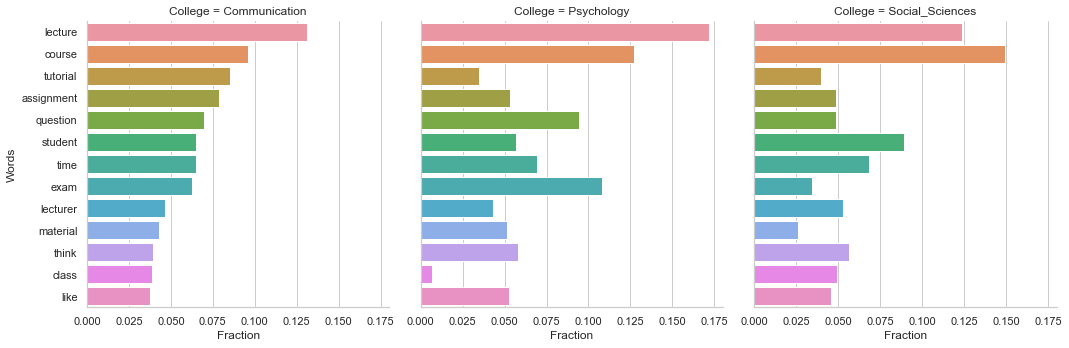

In [88]:
ax = sns.factorplot("Fraction", "Words", col="College", data=df_subset, kind="bar")
plt.show()
fig = ax.fig
fig.savefig("/Users/murieldegroot/UvA/Joris Huese - Muriël/experiments/barchart.png") 

In [91]:
df_corr = df_master.pivot(index='Words', columns='College', values='Rank')
df_corr = df_corr.reset_index(drop=True)
df_corr.corr(method='spearman').round(3)

College,Communication,Psychology,Social_Sciences
College,,,
Communication,1.000,0.806,0.818
Psychology,0.806,1.000,0.796
Social_Sciences,0.818,0.796,1.000


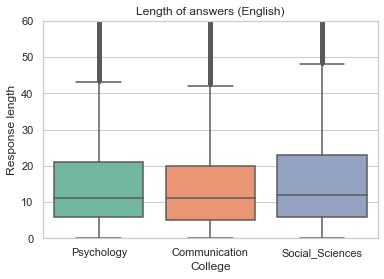

In [103]:
length_df = df_en[["College","Response length"]]
length_df = df_en.loc[(df_en['College'] == "Psychology") | (df_en['College'] == "Communication") | (df_en['College'] == "Social_Sciences")]
length_df = length_df[["College","Response length"]]
length_df = length_df.reset_index(drop=True)

sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="College",y="Response length", data = length_df, palette="Set2")
ax.set(ylim=(0,60), title='Length of answers (English)')
plt.show()
fig = ax.get_figure()
fig.savefig("/Users/murieldegroot/UvA/Joris Huese - Muriël/experiments/boxplot.png") 